In [3]:
!pip install wget
import tarfile
import numpy as np
import re
from glob import glob
import pandas as pd
import pickle
import os
import wget
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt
from mammo_utils import extract_tar, read_pgm, download_file


# Batch generator
def get_batches(X, y, batch_size, distort=True):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y))
    np.random.shuffle(shuffled_idx)
    i, h, w, c = X.shape
    
    # Enumerate indexes by steps of batch_size
    for i in range(0, len(y), batch_size):
        batch_idx = shuffled_idx[i:i+batch_size]
        X_return = X[batch_idx]
        
        # do random flipping of images
        coin = np.random.binomial(1, 0.5, size=None)
        if coin and distort:
            X_return = X_return[...,::-1,:]
        
        yield X_return, y[batch_idx]

C:\Users\eric\Anaconda2\envs\exts-aml2\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Download Data

In [4]:
## Labels
if not os.path.exists(os.path.join("data","labels.pkl")):
    # get the files from AWS
    _ = download_file('https://s3.eu-central-1.amazonaws.com/aws.skoo.ch/files/labels.pkl', 'labels.pkl')

labels = pd.read_pickle(os.path.join("data","labels.pkl"))
  
if not os.path.exists(os.path.join("data","names.npy")):  
    # get the files from AWS
    _ = download_file('https://s3.eu-central-1.amazonaws.com/aws.skoo.ch/files/names.npy', 'names.npy')
  
names = np.load(os.path.join("data","names.npy"))
  
if not os.path.exists(os.path.join("data","all_cases_df.pkl")):  
    # get the files from AWS
    _ = download_file('https://s3.eu-central-1.amazonaws.com/aws.skoo.ch/files/all_cases_df.pkl', 'all_cases_df.pkl')
  
all_cases_df = pd.read_pickle(os.path.join("data","all_cases_df.pkl"))

## Small Images
if not os.path.exists(os.path.join("data","small_images.npy")):
    # get the files from AWS
    _ = download_file('https://s3.eu-central-1.amazonaws.com/aws.skoo.ch/files/small_images.npy', 'small_images.npy')

images = np.load(os.path.join("data","medium_images.npy"))
images = images.reshape([-1,512,512,1])

In [3]:
## Big Images
if False:
    if not os.path.exists(os.path.join("data","data/all-mias.tar.gz")):
        # get the files from AWS
        download_file('https://s3.eu-central-1.amazonaws.com/aws.skoo.ch/files/all-mias.tar.gz', 'all-mias.tar.gz')

        # extract the images
        extract_tar(os.path.join("data","all-mias.tar.gz"))

    if not os.path.exists(os.path.join("data","images.npy")):
        # read all pgms in
        files = glob('./data/pgms/*.pgm')
        data = []

        for file in files:
            # read each file in and convert it to a float
            data.append(read_pgm(file) * 1.0)

        images = np.array(data, dtype=np.float32)

        # save the data to a file so we don't have to keep downloading it
        np.save(os.path.join('data','images.npy'), images)

    else:
        images = np.load('images.npy')

In [5]:
# pick how to classify the data
y_tr = labels.CLASS_Y
num_classes = len(np.unique(y_tr))

# train on entire data set for now, it's not big enough to split into test and train
X_tr = images

X_cv = X_tr
y_cv = y_tr

## Create Model

In [6]:
# config
epochs = 1                 
batch_size = 16

# learning rate decay variables
steps_per_epoch = X_tr.shape[0] / batch_size

## Hyperparameters
# Small epsilon value for the BN transform
epsilon = 1e-8

# learning rate
epochs_per_decay = 10
starting_rate = 0.003
decay_factor = 0.85
staircase = True

# lambdas
lamC = 0.00005
lamF = 0.00100

# use dropout
dropout = False

In [6]:
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = True
model_name = "model_0.0.2"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 299, 299, 1])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    learning_rate = tf.train.exponential_decay(starting_rate,                 
                                               global_step, 
                                               steps_per_epoch * epochs_per_decay,
                                               decay_factor,                  
                                               staircase=staircase) 
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=32,                  # 64 filters
            kernel_size=(7, 7),        # Kernel size: 20x20
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1'                 
        )

        # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        #apply relu
        conv1_bn_relu = tf.nn.relu(bn1, name='relu1')
      
        if dropout:
            conv1_bn_relu = tf.layers.dropout(conv1_bn_relu, rate=0.1, seed=9, training=training)
        
    with tf.name_scope('pool1') as scope:
        # Max pooling layer 1
        pool1 = tf.layers.max_pooling2d(
            conv1_bn_relu,               # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )
        
        if dropout:
          # dropout at 10%
          pool1 = tf.layers.dropout(pool1, rate=0.1, seed=1, training=training)
          
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 2
        conv2 = tf.layers.conv2d(
            pool1,                       # Input data
            filters=64,                 # 128 filters
            kernel_size=(5, 5),        # Kernel size: 15x15
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2'                 
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        #apply relu
        conv2_bn_relu = tf.nn.relu(bn2, name='relu2')
      
        if dropout:
            conv2_bn_relu = tf.layers.dropout(conv2_bn_relu, rate=0.1, seed=9, training=training)
          
    with tf.name_scope('pool2') as scope:
        # Max pooling layer 2
        pool2 = tf.layers.max_pooling2d(
            conv2_bn_relu,               # Input
            pool_size=(2, 2),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool2'
        )
        
        if dropout:
          # dropout at 10%
          pool2 = tf.layers.dropout(pool2, rate=0.1, seed=1, training=training)
          
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3 = tf.layers.conv2d(
            pool2,                       # Input data
            filters=128,                 # 256 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3'                 
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        #apply relu
        conv3_bn_relu = tf.nn.relu(bn3, name='relu3')
      
        if dropout:
            conv3_bn_relu = tf.layers.dropout(conv3_bn_relu, rate=0.1, seed=9, training=training)
    
    with tf.name_scope('pool3') as scope:
        # Average pooling layer 3
        pool3 = tf.layers.average_pooling2d(
            conv3_bn_relu,               # Input
            pool_size=(2, 2),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool3'
        )
        
        if dropout:
          # dropout at 10%
          pool3 = tf.layers.dropout(pool3, rate=0.1, seed=1, training=training)
          
    # Flatten output
    with tf.name_scope('flatten') as scope:
        flat_output = tf.contrib.layers.flatten(pool3)

        if dropout:
          # dropout at 10%
          flat_output = tf.layers.dropout(flat_output, rate=0.1, seed=5, training=training)
          
    # Fully connected layer 1
    with tf.name_scope('fc1') as scope:
        fc1 = tf.layers.dense(
            flat_output,                 # input
            1024,                        # 2048 hidden units
            activation=None,             # None
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=4),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamF),
            name="fc1"
        )
        
        bn7 = tf.layers.batch_normalization(
            fc1,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn7'
        )
        
        fc1_relu = tf.nn.relu(bn7, name='fc1_relu')
        
        if dropout:
          # dropout at 25%
          fc1_relu = tf.layers.dropout(fc1_relu, rate=0.25, seed=10, training=training)
    
    # Fully connected layer 2
    with tf.name_scope('fc2') as scope:
        fc2 = tf.layers.dense(
            fc1_relu,                     # input
            512,                       # 1024 hidden units
            activation=None,            # None
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=5),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamF),
            name="fc2"
        )
        
        bn8 = tf.layers.batch_normalization(
            fc2,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn8'
        )
        
        fc2_relu = tf.nn.relu(bn8, name='fc2_relu')
        
        if dropout:
          # dropout at 10%
          fc2_relu = tf.layers.dropout(fc2_relu, rate=0.25, seed=11, training=training)
          
    # Output layer
    logits = tf.layers.dense(
        fc2_relu,                      # input
        num_classes,                 # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=6),
        bias_initializer=tf.zeros_initializer(),
        name="logits"
    )
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('learning_rate', learning_rate)
    tf.summary.scalar('loss', loss)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

In [7]:
graph = tf.Graph()
# whether to retrain model from scratch or use saved model
init = True
model_name = "model_0.0.9"

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 512, 512, 1])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    training = tf.placeholder(dtype=tf.bool)
    
    # create global step for decaying learning rate
    global_step = tf.Variable(0, trainable=False)
    
    learning_rate = tf.train.exponential_decay(starting_rate,                 
                                               global_step, 
                                               steps_per_epoch * epochs_per_decay,
                                               decay_factor,                  
                                               staircase=staircase) 
    
    with tf.name_scope('conv1') as scope:
        # Convolutional layer 1 
        conv1 = tf.layers.conv2d(
            X,                           # Input data
            filters=32,                  # 32 filters
            kernel_size=(7, 7),          # Kernel size: 9x9
            strides=(2, 2),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv1'                 
        )

        # try batch normalization
        bn1 = tf.layers.batch_normalization(
            conv1,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn1'
        )

        #apply relu
        conv1_bn_relu = tf.nn.relu(bn1, name='relu1')
      
        if dropout:
            conv1_bn_relu = tf.layers.dropout(conv1_bn_relu, rate=0.1, seed=9, training=training)
    
    with tf.name_scope('pool0') as scope:
        # Max pooling layer 0
        pool0 = tf.layers.average_pooling2d(
            conv1_bn_relu,               # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool0'
        )
        
        if dropout:
          # dropout at 10%
          pool0 = tf.layers.dropout(pool0, rate=0.1, seed=1, training=training)
          
    with tf.name_scope('conv2') as scope:
        # Convolutional layer 1 
        conv2 = tf.layers.conv2d(
            pool0,                           # Input data
            filters=32,                  # 32 filters
            kernel_size=(3, 3),          # Kernel size: 9x9
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv2'                 
        )

        # try batch normalization
        bn2 = tf.layers.batch_normalization(
            conv2,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn2'
        )

        #apply relu
        conv2_bn_relu = tf.nn.relu(bn2, name='relu2')
      
        if dropout:
            conv2_bn_relu = tf.layers.dropout(conv2_bn_relu, rate=0.1, seed=9, training=training)
            
    with tf.name_scope('pool1') as scope:
        # Max pooling layer 1
        pool1 = tf.layers.average_pooling2d(
            conv2_bn_relu,               # Input
            pool_size=(3, 3),            # Pool size: 3x3
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool1'
        )
        
        if dropout:
          # dropout at 10%
          pool1 = tf.layers.dropout(pool1, rate=0.1, seed=1, training=training)
          
    with tf.name_scope('conv3') as scope:
        # Convolutional layer 3
        conv3 = tf.layers.conv2d(
            pool1,                       # Input data
            filters=48,                  # 48 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv3'                 
        )

        # try batch normalization
        bn3 = tf.layers.batch_normalization(
            conv3,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn3'
        )

        #apply relu
        conv3_bn_relu = tf.nn.relu(bn3, name='relu3')
      
        if dropout:
            conv3_bn_relu = tf.layers.dropout(conv3_bn_relu, rate=0.1, seed=9, training=training)
    
    with tf.name_scope('conv4') as scope:
        # Convolutional layer 4
        conv4 = tf.layers.conv2d(
            conv3_bn_relu,                       # Input data
            filters=48,                  # 48 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv4'                 
        )

        # try batch normalization
        bn4 = tf.layers.batch_normalization(
            conv4,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn4'
        )

        #apply relu
        conv4_bn_relu = tf.nn.relu(bn4, name='relu4')
      
        if dropout:
            conv4_bn_relu = tf.layers.dropout(conv4_bn_relu, rate=0.1, seed=9, training=training)
    
    with tf.name_scope('pool2') as scope:
        # Max pooling layer 2
        pool2 = tf.layers.max_pooling2d(
            conv4_bn_relu,               # Input
            pool_size=(2, 2),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool2'
        )
        
        if dropout:
          # dropout at 10%
          pool2 = tf.layers.dropout(pool2, rate=0.1, seed=1, training=training)
          
    with tf.name_scope('conv5') as scope:
        # Convolutional layer 5
        conv5 = tf.layers.conv2d(
            pool2,                       # Input data
            filters=64,                  # 64 filters
            kernel_size=(3, 3),          # Kernel size: 5x5
            strides=(1, 1),              # Stride: 1
            padding='SAME',              # "same" padding
            activation=None,             # None
            kernel_initializer=tf.truncated_normal_initializer(stddev=5e-2, seed=10),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamC),
            name='conv5'                 
        )

        # try batch normalization
        bn5 = tf.layers.batch_normalization(
            conv5,
            axis=-1,
            momentum=0.99,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn5'
        )

        #apply relu
        conv5_bn_relu = tf.nn.relu(bn5, name='relu5')
      
        if dropout:
            conv5_bn_relu = tf.layers.dropout(conv5_bn_relu, rate=0.1, seed=9, training=training)
    
    with tf.name_scope('pool3') as scope:
        # Average pooling layer 3
        pool3 = tf.layers.max_pooling2d(
            conv5_bn_relu,               # Input
            pool_size=(2, 2),            # Pool size: 2x2
            strides=(2, 2),              # Stride: 2
            padding='SAME',              # "same" padding
            name='pool3'
        )
        
        if dropout:
          # dropout at 10%
          pool3 = tf.layers.dropout(pool3, rate=0.1, seed=1, training=training)
    
    # Flatten output
    with tf.name_scope('flatten') as scope:
        flat_output = tf.contrib.layers.flatten(pool3)

        # dropout at 10%
        flat_output = tf.layers.dropout(flat_output, rate=0.25, seed=5, training=training)
   
    # Fully connected layer 1
    with tf.name_scope('fc1') as scope:
        fc1 = tf.layers.dense(
            flat_output,                 # input
            512,                        # 2048 hidden units
            activation=None,             # None
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=4),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamF),
            name="fc1"
        )
        
        bn7 = tf.layers.batch_normalization(
            fc1,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn7'
        )
        
        fc1_relu = tf.nn.relu(bn7, name='fc1_relu')
      
        # dropout at 25%
        fc1_relu = tf.layers.dropout(fc1_relu, rate=0.5, seed=10, training=training)

    # Fully connected layer 2
    with tf.name_scope('fc2') as scope:
        fc2 = tf.layers.dense(
            fc1_relu,                     # input
            256,                       # 1024 hidden units
            activation=None,            # None
            kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=5),
            bias_initializer=tf.zeros_initializer(),
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=lamF),
            name="fc2"
        )
        
        bn8 = tf.layers.batch_normalization(
            fc2,
            axis=-1,
            momentum=0.9,
            epsilon=epsilon,
            center=True,
            scale=True,
            beta_initializer=tf.zeros_initializer(),
            gamma_initializer=tf.ones_initializer(),
            moving_mean_initializer=tf.zeros_initializer(),
            moving_variance_initializer=tf.ones_initializer(),
            training=training,
            name='bn8'
        )
        
        fc2_relu = tf.nn.relu(bn8, name='fc2_relu')
        
        # dropout at 10%
        fc2_relu = tf.layers.dropout(fc2_relu, rate=0.5, seed=11, training=training)

    # Output layer
    logits = tf.layers.dense(
        fc2_relu,                      # input
        num_classes,                 # One output unit per category
        activation=None,             # No activation function
        kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=6),
        bias_initializer=tf.zeros_initializer(),
        name="logits"
    )
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    loss = mean_ce + tf.losses.get_regularization_loss()
    
    # Adam optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    # Minimize cross-entropy
    train_op = optimizer.minimize(loss, global_step=global_step)

    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))
    
    # add this so that the batch norm gets run
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Create summary hooks
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cross_entropy', mean_ce)
    tf.summary.scalar('learning_rate', learning_rate)
    tf.summary.scalar('loss', loss)
    
    # Merge all the summaries and write them out to /tmp/mnist_logs (by default)
    merged = tf.summary.merge_all()

## Train

In [8]:
## CONFIGURE OPTIONS
init = True                   # whether to initialize the model or use a saved version
crop = False                  # do random cropping of images?

meta_data_every = 5
log_to_tensorboard = True
print_every = 3                # how often to print metrics
checkpoint_every = 1           # how often to save model in epochs
use_gpu = False                 # whether or not to use the GPU
print_metrics = False          # whether to print or plot metrics, if False a plot will be created and updated every epoch

# Placeholders for metrics
if init:
    valid_acc_values = []
    valid_cost_values = []
    train_acc_values = []
    train_cost_values = []
    train_lr_values = []
    train_loss_values = []
    

if use_gpu:
    config = tf.ConfigProto()
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.7
else:
    config = tf.ConfigProto(device_count = {'GPU': 0})

Training model_0.0.9 ...


KeyboardInterrupt: 

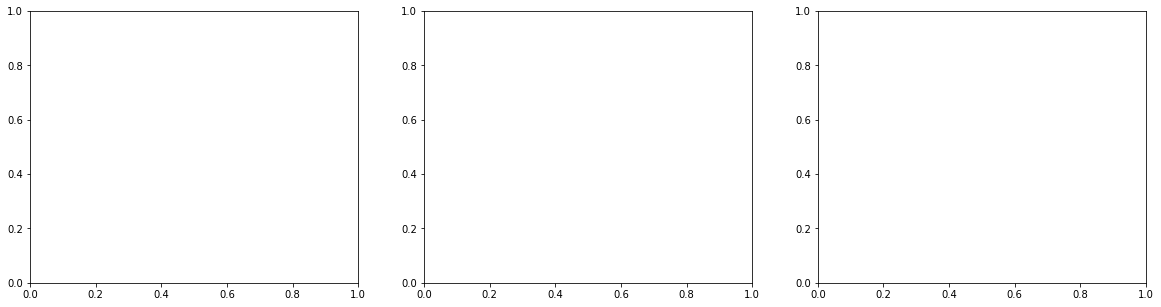

In [9]:
# train the model
with tf.Session(graph=graph, config=config) as sess:
    if log_to_tensorboard:
        train_writer = tf.summary.FileWriter('./logs/tr_' + model_name, sess.graph)
        test_writer = tf.summary.FileWriter('./logs/te_' + model_name)
    
    if not print_metrics:
        # create a plot to be updated as model is trained
        f, ax = plt.subplots(1,3,figsize=(20,5))
    
    # create the saver
    saver = tf.train.Saver()
    
    # If the model is new initialize variables, else restore the session
    if init:
        sess.run(tf.global_variables_initializer())
    else:
        saver.restore(sess, './model/'+model_name+'.ckpt')

    # Set seed
    np.random.seed(0)
    
    print("Training", model_name, "...")
    
    # Train several epochs
    for epoch in range(epochs):
        # Accuracy values (train) after each batch
        batch_acc = []
        batch_cost = []
        batch_loss = []
        batch_lr = []
        
        # only log run metadata once per epoch
        write_meta_data = False
            
        for X_batch, y_batch in get_batches(X_tr, y_tr, batch_size, distort=True):
            if write_meta_data and log_to_tensboard:
                # create the metadata
                run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                run_metadata = tf.RunMetadata()
            
                # Run training and evaluate accuracy
                _, _, summary, acc_value, cost_value, loss_value, step, lr = sess.run([train_op, extra_update_ops, merged, accuracy, mean_ce, loss, global_step, learning_rate], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    training: True
                },
                options=run_options,
                run_metadata=run_metadata)

                # Save accuracy (current batch)
                batch_acc.append(acc_value)
                batch_cost.append(cost_value)
                batch_lr.append(lr)
                batch_loss.append(loss_value)
  
                # write the summary
                train_writer.add_run_metadata(run_metadata, 'step %d' % step)
                train_writer.add_summary(summary, step)
                write_meta_data = False
                
            else:
                # Run training without meta data
                _, _, summary, acc_value, cost_value, loss_value, step, lr = sess.run([train_op, extra_update_ops, merged, accuracy, mean_ce, loss, global_step, learning_rate], feed_dict={
                    X: X_batch,
                    y: y_batch,
                    training: True
                })

                # Save accuracy (current batch)
                batch_acc.append(acc_value)
                batch_cost.append(cost_value)
                batch_lr.append(lr)
                batch_loss.append(loss_value)
                
                # write the summary
                if log_to_tensorboard:
                    train_writer.add_summary(summary, step)

        # save checkpoint every nth epoch
        if(epoch % checkpoint_every == 0):
            print("Saving checkpoint")
            # save the model
            save_path = saver.save(sess, './model/'+model_name+'.ckpt')
    
            # Now that model is saved set init to false so we reload it
            init = False
        
        # init batch arrays
        batch_cv_acc = []
        batch_cv_cost = []
        batch_cv_loss = []
        
        # Evaluate validation accuracy with batches so as to not crash the GPU
        for X_batch, y_batch in get_batches(X_cv, y_cv, batch_size, distort=False):
            summary, valid_acc, valid_cost, valid_loss = sess.run([merged, accuracy, mean_ce, loss], feed_dict={
                X: X_batch,
                y: y_batch,
                training: False
            })

            batch_cv_acc.append(valid_acc)
            batch_cv_cost.append(valid_cost)
            batch_cv_loss.append(valid_loss)

        # Write average of validation data to summary logs
        if log_to_tensorboard:
            summary = tf.Summary(value=[tf.Summary.Value(tag="accuracy", simple_value=np.mean(batch_cv_acc)),tf.Summary.Value(tag="cross_entropy", simple_value=np.mean(batch_cv_cost)),])
            test_writer.add_summary(summary, step)
            step += 1
            
        # take the mean of the values to add to the metrics
        valid_acc_values.append(np.mean(batch_cv_acc))
        valid_cost_values.append(np.mean(batch_cv_cost))
        train_acc_values.append(np.mean(batch_acc))
        train_cost_values.append(np.mean(batch_cost))
        train_lr_values.append(np.mean(batch_lr))
        train_loss_values.append(np.mean(batch_loss))
        
        if print_metrics:
            # Print progress every nth epoch to keep output to reasonable amount
            if(epoch % print_every == 0):
                print('Epoch {:02d} - step {} - cv acc: {:.3f} - train acc: {:.3f} (mean) - cv cost: {:.3f} - lr: {:.5f}'.format(
                    epoch, step, np.mean(batch_cv_acc), np.mean(batch_acc), np.mean(batch_cv_cost), lr
                ))
        else:
            # update the plot
            ax[0].cla()
            ax[0].plot(valid_acc_values, color="red", label="Validation")
            ax[0].plot(train_acc_values, color="blue", label="Training")
            ax[0].set_title('Validation accuracy: {:.4f} (mean last 3)'.format(np.mean(valid_acc_values[-4:])))
            
            # since we can't zoom in on plots like in tensorboard, scale y axis to give a decent amount of detail
            if np.mean(valid_acc_values[-3:]) > 0.90:
                ax[0].set_ylim([0.80,1.0])
            elif np.mean(valid_acc_values[-3:]) > 0.85:
                ax[0].set_ylim([0.75,1.0])
            elif np.mean(valid_acc_values[-3:]) > 0.75:
                ax[0].set_ylim([0.65,1.0])
            elif np.mean(valid_acc_values[-3:]) > 0.65:
                ax[0].set_ylim([0.55,1.0])
            elif np.mean(valid_acc_values[-3:]) > 0.55:
                ax[0].set_ylim([0.45,1.0])           
            
            ax[0].set_xlabel('Epoch')
            ax[0].set_ylabel('Accuracy')
            ax[0].legend()
            
            ax[1].cla()
            ax[1].plot(valid_cost_values, color="red", label="Validation")
            ax[1].plot(train_cost_values, color="blue", label="Training")
            ax[1].set_title('Validation xentropy: {:.3f} (mean last 3)'.format(np.mean(valid_cost_values[-4:])))
            ax[1].set_xlabel('Epoch')
            ax[1].set_ylabel('Cross Entropy')
            ax[1].set_ylim([0,2.0])
            ax[1].legend()
            
            ax[2].cla()
            ax[2].plot(train_lr_values)
            ax[2].set_title("Learning rate: {:.6f}".format(np.mean(train_lr_values[-1:])))
            ax[2].set_xlabel("Epoch")
            ax[2].set_ylabel("Learning Rate")
            
            display.display(plt.gcf())
            display.clear_output(wait=True)
            
        # Print data every 50th epoch so I can write it down to compare models
        if (not print_metrics) and (epoch % 50 == 0) and (epoch > 1):
            if(epoch % print_every == 0):
                print('Epoch {:02d} - step {} - cv acc: {:.4f} - train acc: {:.3f} (mean) - cv cost: {:.3f} - lr: {:.5f}'.format(
                    epoch, step, np.mean(batch_cv_acc), np.mean(batch_acc), np.mean(batch_cv_cost), lr
                ))  
            
    # print results of last epoch
    print('Epoch {} - cv acc: {:.4f} - train acc: {:.4f} (mean) - cv cost: {:.3f}'.format(
                epochs, np.mean(batch_cv_acc), np.mean(batch_acc), np.mean(batch_cv_cost)
            ))
    
    # save the session
    save_path = saver.save(sess, './model/'+model_name+'.ckpt')
    
    # init the test data array
    test_acc_values = []
    
    # Check on the test data
    #for X_batch, y_batch in get_batches(X_te, y_te, batch_size, distort=False):
    #    test_accuracy = sess.run(accuracy, feed_dict={
    #        X: X_batch,
    #        y: y_batch,
    #        training: False
    #    })
    #    test_acc_values.append(test_accuracy)
    
    # average test accuracy across batches
    #test_acc = np.mean(test_acc_values)
    
# show the plot
plt.show()

# print results of last epoch
print('Epoch {} - cv acc: {:.4f} - train acc: {:.4f} (mean) - cv cost: {:.3f}'.format(
      epochs, np.mean(batch_cv_acc), np.mean(batch_acc), np.mean(batch_cv_cost)
    ))
    
# print test accuracy
#print("Convolutional network accuracy (test set):",test_acc, " Validation set:", valid_acc_values[-1])